## Install Prerequisites

In [ ]:
import subprocess
import sys
import base64
import getpass
import requests
subprocess.check_call([sys.executable, "-m", "pip", "install", "pyyaml"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "networkx"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "plotly"])
import yaml
import matplotlib
import plotly.graph_objects as go
import networkx as nx
import webbrowser

## Create ExoGeni Credentials 
Upload ExoGeni Credentials from ~/.ssl/user.jks

In [2]:
with open("user.jks", "rb") as image_file:
    exoGENI_keystore_as_base64 = base64.b64encode(image_file.read()).decode("utf-8") 


FileNotFoundError: [Errno 2] No such file or directory: 'user.jks'

In [3]:
exoGENI_credential_user  = getpass.getpass('Enter your ExoGENI_credential_user')

KeyboardInterrupt: Interrupted by user

In [ ]:
exoGENI_credential_token = getpass.getpass("Enter your ExoGENI_credential_token " )

## Create EC2 Credentials 

In [6]:
aws_access_key_id  = getpass.getpass('Enter your aws_access_key_id')

Enter your aws_access_key_id········


In [7]:
aws_secret_access_key  = getpass.getpass('Enter your aws_secret_access_key')

Enter your aws_secret_access_key········


In [17]:
username  = getpass.getpass('Enter your username')

Enter your username········


In [18]:
password  = getpass.getpass('Enter your password')

Enter your password········


## Enter API URL

In [19]:
# base_url = input("Enter host base_url " )
# http://manager:8080
# http://localhost:30000
base_url = 'https://lifewatch.lab.uvalight.net:30001/manager'
print(base_url)

https://lifewatch.lab.uvalight.net:30001/manager


## Upload Credentials

In [14]:
path = "/credential"
payload = '{"cloud_provider_name": "ExoGENI","keys": {"keystore": "'+exoGENI_keystore_as_base64+'"}, "token": "'+exoGENI_credential_token+'",  "token_type": "password",  "user": "'+exoGENI_credential_user+'"}'
headers = {
  'Content-Type': 'application/json',
   'accept': 'application/json'
}
response = requests.post(base_url+path, data=payload,headers=headers)
credential_id = response.text
print(credential_id)

NameError: name 'exoGENI_keystore_as_base64' is not defined

In [21]:
path = "/credential"
payload = '{ "cloud_provider_name": "EC2","keys": {"aws_access_key_id": "'+aws_access_key_id+'"},  "token_type": "access_key", "token": "'+aws_secret_access_key+'"}' 
headers = {
  'Content-Type': 'application/json',
   'accept': 'application/json'
}


response = requests.post(base_url+path, data=payload,headers=headers,verify=False, auth=(username, password))
credential_id = response.text
print(credential_id)

5efb35329c8dc53728a46cfc


/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:986: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lifewatch.lab.uvalight.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


## Upload TOSCA

In [24]:
path = "/tosca_template"
payload = {}
filename = 'lifeWatch_vre1.yaml'
fin = open(filename, 'rb')
files = {'file': fin}

headers = {}

response = requests.request("POST", base_url+path, headers=headers, files = files,verify=False, auth=(username, password))
tosca_id = response.text
    

/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:986: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lifewatch.lab.uvalight.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


## Get TOSCA

In [29]:
path = "/tosca_template/"+tosca_id
payload = {}
headers= {'accept':'text/plain'}

response = requests.request("GET", base_url+path, headers=headers, data = payload,verify=False, auth=(username, password))
tosca = response.text
print(tosca)

tosca_definitions_version: "tosca_simple_yaml_1_0"
topology_template:
  node_templates:
    ws-pema:
      properties:
        ports:
        - "30001:8080"
      interfaces:
        Kubernetes:
          delete:
            inputs:
              repository: "https://github.com/QCAPI-DRIP/playbooks.git"
              resources:
              - "k8s/delete_service.yml"
          create:
            inputs:
              repository: "https://github.com/QCAPI-DRIP/playbooks.git"
              resources:
              - "k8s/create_service.yml"
          scale:
            inputs:
              repository: "https://github.com/QCAPI-DRIP/playbooks.git"
              resources:
              - "k8s/scale_service.yml"
              replicas: 1
          autoscale:
            inputs:
              repository: "https://github.com/QCAPI-DRIP/playbooks.git"
              resources:
              - "k8s/autoscale_service.yml"
              horizontal_pod_autoscaler: "horizontal_pod_autoscaler.yml

/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:986: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lifewatch.lab.uvalight.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


## Show Topology

/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:986: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lifewatch.lab.uvalight.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


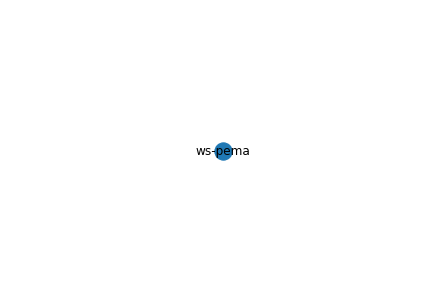

In [38]:



def build_graph(node_templates):
    graph = nx.DiGraph()
    for node_name in node_templates:
        graph.add_node(node_name, attr_dict=node_templates[node_name])
        if 'requirements' in node_templates[node_name]:
            for req in node_templates[node_name]['requirements']:
                req_name = next(iter(req))
                req_node_name = req[req_name]['node']
                if 'relationship' in req[req_name] and 'type' in req[req_name]['relationship']:
                    relationship_type = req[req_name]['relationship']['type']
                else:
                    if 'relationship' not in req[req_name]:
                        relationship_type = 'tosca.relationships.DependsOn'
                    else:
                        relationship_type = req[req_name]['relationship']
                graph.add_edge(node_name, req_node_name, relationship=relationship_type)

    # nx.draw(graph, with_labels=True)
    # plt.savefig("/tmp/graph.png")
    # plt.show()
    return graph

def get_tosca(tosca_id):
    path = "/tosca_template/"+tosca_id
    payload = {}
    headers= {'accept':'text/plain'}
    response = requests.request("GET", base_url+path, headers=headers, data = payload,verify=False, auth=(username, password))
    return response.text

tosca = get_tosca(tosca_id)
tosca_dict = yaml.safe_load(tosca)
graph = build_graph(tosca_dict['topology_template']['node_templates'])
nx.draw(graph, with_labels=True)


## Make Plan

In [39]:
path = "/planner/plan/"+tosca_id
payload = {}
headers= {'accept':'text/plain'}

response = requests.request("GET", base_url+path, headers=headers, data = payload,verify=False, auth=(username, password))
planed_tosca_id = response.text

/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:986: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lifewatch.lab.uvalight.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:986: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lifewatch.lab.uvalight.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


compute: {'disk_size': '20000 MB', 'mem_size': '1000 MB', 'num_cores': 1, 'os': 'Ubuntu 18.04', 'user_name': 'vm_user'}
---------------------------------------------------------------------------------------------------------------------
compute_1: {'disk_size': '20000 MB', 'mem_size': '1000 MB', 'num_cores': 1, 'os': 'Ubuntu 18.04', 'user_name': 'vm_user'}
---------------------------------------------------------------------------------------------------------------------
topology: {'domain': 'Frankfurt', 'provider': 'EC2'}
---------------------------------------------------------------------------------------------------------------------
ws-pema: {'ports': ['30001:8080']}
---------------------------------------------------------------------------------------------------------------------


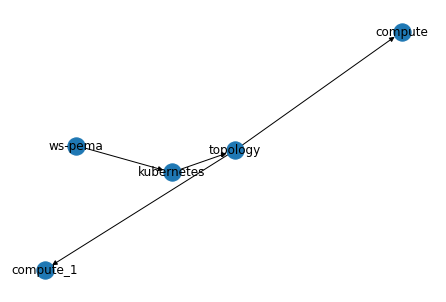

In [40]:
tosca = get_tosca(planed_tosca_id)

tosca_dict = yaml.safe_load(tosca)
graph = build_graph(tosca_dict['topology_template']['node_templates'])
nx.draw(graph, with_labels=True)

for node_name in tosca_dict['topology_template']['node_templates']:
    if 'properties' in tosca_dict['topology_template']['node_templates'][node_name]:
        print(node_name+': '+str(tosca_dict['topology_template']['node_templates'][node_name]['properties']))
        print('---------------------------------------------------------------------------------------------------------------------')
        
        

## Provision Plan

In [41]:
path = "/provisioner/provision/"+planed_tosca_id
payload = {}
headers= {'accept':'text/plain'}

response = requests.request("GET", base_url+path, headers=headers, data = payload,verify=False, auth=(username, password))
provisioned_tosca_id = response.text

/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:986: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lifewatch.lab.uvalight.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:986: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lifewatch.lab.uvalight.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


compute: 3.120.209.252
compute_1: 3.126.139.56


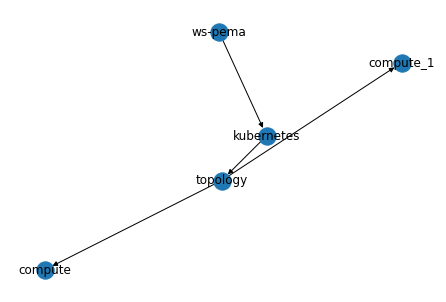

In [42]:
tosca = get_tosca(provisioned_tosca_id)

tosca_dict = yaml.safe_load(tosca)
graph = build_graph(tosca_dict['topology_template']['node_templates'])
nx.draw(graph, with_labels=True)


for node_name in tosca_dict['topology_template']['node_templates']:
    if tosca_dict['topology_template']['node_templates'][node_name]['type'] == 'tosca.nodes.QC.VM.Compute':
        print(node_name+': '+tosca_dict['topology_template']['node_templates'][node_name]['attributes']['public_ip'])

## Deploy K8s And WS

In [ ]:
path = "/deployer/deploy/"+provisioned_tosca_id
payload = {}
headers= {'accept':'text/plain'}

response = requests.request("GET", base_url+path, headers=headers, data = payload, verify=False, auth=(username, password))
deployed_tosca_id = response.text

/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:986: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lifewatch.lab.uvalight.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [ ]:
tosca = get_tosca(deployed_tosca_id)

tosca_dict = yaml.safe_load(tosca)
graph = build_graph(tosca_dict['topology_template']['node_templates'])
nx.draw(graph, with_labels=True)

for node_name in tosca_dict['topology_template']['node_templates']:
    if tosca_dict['topology_template']['node_templates'][node_name]['type'] == 'tosca.nodes.QC.docker.Orchestrator.Kubernetes':
        for token in tosca_dict['topology_template']['node_templates'][node_name]['attributes']['tokens']:
            if token['user'] == 'dashboard_token':
                print(node_name+': '+' dashboard_token: '+token['token'])
        print(node_name+': '+str(tosca_dict['topology_template']['node_templates'][node_name]['attributes']['dashboard_url']))
    if tosca_dict['topology_template']['node_templates'][node_name]['type'] == 'tosca.nodes.QC.Container.Application.Docker':
        print(node_name+': '+str(tosca_dict['topology_template']['node_templates'][node_name]['attributes']['service_url']))
        